In [2]:
from ompl import base as ob
from ompl import geometric as og
def isStateValid(state):
    x = state[0]
    y = state[1]

    if 0.4 <= x <= 0.6 and 0.4 <= y <= 0.6:
        return False
    return True

def plan():
    # Zustandsraum: 2D Quadrat von (0,0) bis (1,1)
    space = ob.RealVectorStateSpace(2)

    # Grenzen setzen
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0)
    bounds.setHigh(1)
    space.setBounds(bounds)

    # Erstelle den Planer-Space Information
    si = ob.SpaceInformation(space)
    si.setStateValidityChecker(ob.StateValidityCheckerFn(isStateValid))
    si.setup()

    # Start- und Zielzustand
    start = ob.State(space)
    start[0] = 0.1
    start[1] = 0.1

    goal = ob.State(space)
    goal[0] = 0.9
    goal[1] = 0.9

    # Erstelle das Problem und setze Start und Ziel
    pdef = ob.ProblemDefinition(si)
    pdef.setStartAndGoalStates(start, goal)

    # Wähle einen Planner, z.B. RRTConnect
    planner = og.RRTConnect(si)
    planner.setProblemDefinition(pdef)
    planner.setup()

    # Versuche einen Pfad zu finden
    solved = planner.solve(5.0)

    if solved:
        print("Pfad gefunden:")
        path = pdef.getSolutionPath()
        print(path)
    else:
        print("Kein Pfad gefunden")

if __name__ == "__main__":
    plan()


Debug:   RRTConnect: Planner range detected to be 0.282843
Pfad gefunden:
Geometric path with 6 states
RealVectorState [0.1 0.1]
RealVectorState [0.301777 0.298207]
RealVectorState [0.570548 0.386308]
RealVectorState [0.752194 0.44585]
RealVectorState [0.700596 0.699406]
RealVectorState [0.9 0.9]


Info:    RRTConnect: Starting planning with 1 states already in datastructure
Info:    RRTConnect: Created 7 states (4 start + 3 goal)


In [4]:
#!/usr/bin/env python3

######################################################################
# Software License Agreement (BSD License)
#
#  Copyright (c) 2010, Rice University
#  All rights reserved.
#
#  Redistribution and use in source and binary forms, with or without
#  modification, are permitted provided that the following conditions
#  are met:
#
#   * Redistributions of source code must retain the above copyright
#     notice, this list of conditions and the following disclaimer.
#   * Redistributions in binary form must reproduce the above
#     copyright notice, this list of conditions and the following
#     disclaimer in the documentation and/or other materials provided
#     with the distribution.
#   * Neither the name of the Rice University nor the names of its
#     contributors may be used to endorse or promote products derived
#     from this software without specific prior written permission.
#
#  THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
#  "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
#  LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS
#  FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE
#  COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT,
#  INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING,
#  BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
#  LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
#  CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT
#  LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN
#  ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
#  POSSIBILITY OF SUCH DAMAGE.
######################################################################

# Author: Luis G. Torres, Mark Moll

import sys
try:
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
except ImportError:
    # if the ompl module is not in the PYTHONPATH assume it is installed in a
    # subdirectory of the parent directory called "py-bindings."
    from os.path import abspath, dirname, join
    sys.path.insert(0, join(dirname(dirname(abspath(__file__))), 'py-bindings'))
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
from math import sqrt
import argparse

## @cond IGNORE
# Our "collision checker". For this demo, our robot's state space
# lies in [0,1]x[0,1], with a circular obstacle of radius 0.25
# centered at (0.5,0.5). Any states lying in this circular region are
# considered "in collision".
class ValidityChecker(ob.StateValidityChecker):
    # Returns whether the given state's position overlaps the
    # circular obstacle
    def isValid(self, state):
        return self.clearance(state) > 0.0

    # Returns the distance from the given state's position to the
    # boundary of the circular obstacle.
    def clearance(self, state):
        # Extract the robot's (x,y) position from its state
        x = state[0]
        y = state[1]

        # Distance formula between two points, offset by the circle's
        # radius
        return sqrt((x-0.5)*(x-0.5) + (y-0.5)*(y-0.5)) - 0.25


## Returns a structure representing the optimization objective to use
#  for optimal motion planning. This method returns an objective
#  which attempts to minimize the length in configuration space of
#  computed paths.
def getPathLengthObjective(si):
    return ob.PathLengthOptimizationObjective(si)

## Returns an optimization objective which attempts to minimize path
#  length that is satisfied when a path of length shorter than 1.51
#  is found.
def getThresholdPathLengthObj(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostThreshold(ob.Cost(1.51))
    return obj

## Defines an optimization objective which attempts to steer the
#  robot away from obstacles. To formulate this objective as a
#  minimization of path cost, we can define the cost of a path as a
#  summation of the costs of each of the states along the path, where
#  each state cost is a function of that state's clearance from
#  obstacles.
#
#  The class StateCostIntegralObjective represents objectives as
#  summations of state costs, just like we require. All we need to do
#  then is inherit from that base class and define our specific state
#  cost function by overriding the stateCost() method.
#
class ClearanceObjective(ob.StateCostIntegralObjective):
    def __init__(self, si):
        super(ClearanceObjective, self).__init__(si, True)
        self.si_ = si

    # Our requirement is to maximize path clearance from obstacles,
    # but we want to represent the objective as a path cost
    # minimization. Therefore, we set each state's cost to be the
    # reciprocal of its clearance, so that as state clearance
    # increases, the state cost decreases.
    def stateCost(self, s):
        return ob.Cost(1 / (self.si_.getStateValidityChecker().clearance(s) +
                            sys.float_info.min))

## Return an optimization objective which attempts to steer the robot
#  away from obstacles.
def getClearanceObjective(si):
    return ClearanceObjective(si)

## Create an optimization objective which attempts to optimize both
#  path length and clearance. We do this by defining our individual
#  objectives, then adding them to a MultiOptimizationObjective
#  object. This results in an optimization objective where path cost
#  is equivalent to adding up each of the individual objectives' path
#  costs.
#
#  When adding objectives, we can also optionally specify each
#  objective's weighting factor to signify how important it is in
#  optimal planning. If no weight is specified, the weight defaults to
#  1.0.
def getBalancedObjective1(si):
    lengthObj = ob.PathLengthOptimizationObjective(si)
    clearObj = ClearanceObjective(si)

    opt = ob.MultiOptimizationObjective(si)
    opt.addObjective(lengthObj, 5.0)
    opt.addObjective(clearObj, 1.0)

    return opt

## Create an optimization objective equivalent to the one returned by
#  getBalancedObjective1(), but use an alternate syntax.
#  THIS DOESN'T WORK YET. THE OPERATORS SOMEHOW AREN'T EXPORTED BY Py++.
# def getBalancedObjective2(si):
#     lengthObj = ob.PathLengthOptimizationObjective(si)
#     clearObj = ClearanceObjective(si)
#
#     return 5.0*lengthObj + clearObj


## Create an optimization objective for minimizing path length, and
#  specify a cost-to-go heuristic suitable for this optimal planning
#  problem.
def getPathLengthObjWithCostToGo(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostToGoHeuristic(ob.CostToGoHeuristic(ob.goalRegionCostToGo))
    return obj


# Keep these in alphabetical order and all lower case
def allocatePlanner(si, plannerType):
    if plannerType.lower() == "bfmtstar":
        return og.BFMT(si)
    elif plannerType.lower() == "bitstar":
        return og.BITstar(si)
    elif plannerType.lower() == "fmtstar":
        return og.FMT(si)
    elif plannerType.lower() == "informedrrtstar":
        return og.InformedRRTstar(si)
    elif plannerType.lower() == "prmstar":
        return og.PRMstar(si)
    elif plannerType.lower() == "rrtstar":
        return og.RRTstar(si)
    elif plannerType.lower() == "sorrtstar":
        return og.SORRTstar(si)
    else:
        ou.OMPL_ERROR("Planner-type is not implemented in allocation function.")


# Keep these in alphabetical order and all lower case
def allocateObjective(si, objectiveType):
    if objectiveType.lower() == "pathclearance":
        return getClearanceObjective(si)
    elif objectiveType.lower() == "pathlength":
        return getPathLengthObjective(si)
    elif objectiveType.lower() == "thresholdpathlength":
        return getThresholdPathLengthObj(si)
    elif objectiveType.lower() == "weightedlengthandclearancecombo":
        return getBalancedObjective1(si)
    else:
        ou.OMPL_ERROR("Optimization-objective is not implemented in allocation function.")



def plan(runTime, plannerType, objectiveType, fname):
    # Construct the robot state space in which we're planning. We're
    # planning in [0,1]x[0,1], a subset of R^2.
    space = ob.RealVectorStateSpace(2)

    # Set the bounds of space to be in [0,1].
    space.setBounds(0.0, 1.0)

    # Construct a space information instance for this state space
    si = ob.SpaceInformation(space)

    # Set the object used to check which states in the space are valid
    validityChecker = ValidityChecker(si)
    si.setStateValidityChecker(validityChecker)

    si.setup()

    # Set our robot's starting state to be the bottom-left corner of
    # the environment, or (0,0).
    start = ob.State(space)
    start[0] = 0.0
    start[1] = 0.0

    # Set our robot's goal state to be the top-right corner of the
    # environment, or (1,1).
    goal = ob.State(space)
    goal[0] = 1.0
    goal[1] = 1.0

    # Create a problem instance
    pdef = ob.ProblemDefinition(si)

    # Set the start and goal states
    pdef.setStartAndGoalStates(start, goal)

    # Create the optimization objective specified by our command-line argument.
    # This helper function is simply a switch statement.
    pdef.setOptimizationObjective(allocateObjective(si, objectiveType))

    # Construct the optimal planner specified by our command line argument.
    # This helper function is simply a switch statement.
    optimizingPlanner = allocatePlanner(si, plannerType)

    # Set the problem instance for our planner to solve
    optimizingPlanner.setProblemDefinition(pdef)
    optimizingPlanner.setup()

    # attempt to solve the planning problem in the given runtime
    solved = optimizingPlanner.solve(runTime)

    if solved:
        # Output the length of the path found
        print('{0} found solution of path length {1:.4f} with an optimization ' \
            'objective value of {2:.4f}'.format( \
            optimizingPlanner.getName(), \
            pdef.getSolutionPath().length(), \
            pdef.getSolutionPath().cost(pdef.getOptimizationObjective()).value()))

        # If a filename was specified, output the path as a matrix to
        # that file for visualization
        if fname:
            with open(fname, 'w') as outFile:
                outFile.write(pdef.getSolutionPath().printAsMatrix())
    else:
        print("No solution found.")

if __name__ == "__main__":
    # Create an argument parser
    parser = argparse.ArgumentParser(description='Optimal motion planning demo program.')

    # Add a filename argument
    parser.add_argument('-t', '--runtime', type=float, default=1.0, help=\
        '(Optional) Specify the runtime in seconds. Defaults to 1 and must be greater than 0.')
    parser.add_argument('-p', '--planner', default='RRTstar', \
        choices=['BFMTstar', 'BITstar', 'FMTstar', 'InformedRRTstar', 'PRMstar', 'RRTstar', \
        'SORRTstar'], \
        help='(Optional) Specify the optimal planner to use, defaults to RRTstar if not given.')
    parser.add_argument('-o', '--objective', default='PathLength', \
        choices=['PathClearance', 'PathLength', 'ThresholdPathLength', \
        'WeightedLengthAndClearanceCombo'], \
        help='(Optional) Specify the optimization objective, defaults to PathLength if not given.')
    parser.add_argument('-f', '--file', default=None, \
        help='(Optional) Specify an output path for the found solution path.')
    parser.add_argument('-i', '--info', type=int, default=0, choices=[0, 1, 2], \
        help='(Optional) Set the OMPL log level. 0 for WARN, 1 for INFO, 2 for DEBUG.' \
        ' Defaults to WARN.')

    # Parse the arguments
    args = parser.parse_args()

    # Check that time is positive
    if args.runtime <= 0:
        raise argparse.ArgumentTypeError(
            "argument -t/--runtime: invalid choice: %r (choose a positive number greater than 0)" \
            % (args.runtime,))

    # Set the log level
    if args.info == 0:
        ou.setLogLevel(ou.LOG_WARN)
    elif args.info == 1:
        ou.setLogLevel(ou.LOG_INFO)
    elif args.info == 2:
        ou.setLogLevel(ou.LOG_DEBUG)
    else:
        ou.OMPL_ERROR("Invalid log-level integer.")

    # Solve the planning problem
    plan(args.runtime, args.planner, args.objective, args.file)

## @endcond

RRTstar found solution of path length 1.5071 with an optimization objective value of 1.5071


In [27]:
import sys
try:
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
except ImportError:
    # if the ompl module is not in the PYTHONPATH assume it is installed in a
    # subdirectory of the parent directory called "py-bindings."
    from os.path import abspath, dirname, join
    sys.path.insert(0, join(dirname(dirname(abspath(__file__))), 'py-bindings'))
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
from math import sqrt
import argparse

## @cond IGNORE
# Our "collision checker". For this demo, our robot's state space
# lies in [0,1]x[0,1], with a circular obstacle of radius 0.25
# centered at (0.5,0.5). Any states lying in this circular region are
# considered "in collision".
class ValidityChecker(ob.StateValidityChecker):
    # Returns whether the given state's position overlaps the
    # circular obstacle
    def isValid(self, state):
        return self.clearance(state) > 0.0

    # Returns the distance from the given state's position to the
    # boundary of the circular obstacle.
    def clearance(self, state):
        # Extract the robot's (x,y) position from its state
        x = state[0]
        y = state[1]
        z = state[2]

        # Distance formula between three points, offset by the circle's
        # radius
        return sqrt((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2) - 0.25


## Returns a structure representing the optimization objective to use
#  for optimal motion planning. This method returns an objective
#  which attempts to minimize the length in configuration space of
#  computed paths.
def getPathLengthObjective(si):
    return ob.PathLengthOptimizationObjective(si)

## Returns an optimization objective which attempts to minimize path
#  length that is satisfied when a path of length shorter than 1.51
#  is found.
def getThresholdPathLengthObj(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostThreshold(ob.Cost(1.51))
    return obj

## Defines an optimization objective which attempts to steer the
#  robot away from obstacles. To formulate this objective as a
#  minimization of path cost, we can define the cost of a path as a
#  summation of the costs of each of the states along the path, where
#  each state cost is a function of that state's clearance from
#  obstacles.
#
#  The class StateCostIntegralObjective represents objectives as
#  summations of state costs, just like we require. All we need to do
#  then is inherit from that base class and define our specific state
#  cost function by overriding the stateCost() method.
#
class ClearanceObjective(ob.StateCostIntegralObjective):
    def __init__(self, si):
        super(ClearanceObjective, self).__init__(si, True)
        self.si_ = si

    # Our requirement is to maximize path clearance from obstacles,
    # but we want to represent the objective as a path cost
    # minimization. Therefore, we set each state's cost to be the
    # reciprocal of its clearance, so that as state clearance
    # increases, the state cost decreases.
    def stateCost(self, s):
        return ob.Cost(1 / (self.si_.getStateValidityChecker().clearance(s) +
                            sys.float_info.min))

## Return an optimization objective which attempts to steer the robot
#  away from obstacles.
def getClearanceObjective(si):
    return ClearanceObjective(si)

## Create an optimization objective which attempts to optimize both
#  path length and clearance. We do this by defining our individual
#  objectives, then adding them to a MultiOptimizationObjective
#  object. This results in an optimization objective where path cost
#  is equivalent to adding up each of the individual objectives' path
#  costs.
#
#  When adding objectives, we can also optionally specify each
#  objective's weighting factor to signify how important it is in
#  optimal planning. If no weight is specified, the weight defaults to
#  1.0.
def getBalancedObjective1(si):
    lengthObj = ob.PathLengthOptimizationObjective(si)
    clearObj = ClearanceObjective(si)

    opt = ob.MultiOptimizationObjective(si)
    opt.addObjective(lengthObj, 5.0)
    opt.addObjective(clearObj, 1.0)

    return opt

## Create an optimization objective equivalent to the one returned by
#  getBalancedObjective1(), but use an alternate syntax.
#  THIS DOESN'T WORK YET. THE OPERATORS SOMEHOW AREN'T EXPORTED BY Py++.
# def getBalancedObjective2(si):
#     lengthObj = ob.PathLengthOptimizationObjective(si)
#     clearObj = ClearanceObjective(si)
#
#     return 5.0*lengthObj + clearObj


## Create an optimization objective for minimizing path length, and
#  specify a cost-to-go heuristic suitable for this optimal planning
#  problem.
def getPathLengthObjWithCostToGo(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostToGoHeuristic(ob.CostToGoHeuristic(ob.goalRegionCostToGo))
    return obj


# Keep these in alphabetical order and all lower case
def allocatePlanner(si, plannerType):
    if plannerType.lower() == "bfmtstar":
        return og.BFMT(si)
    elif plannerType.lower() == "bitstar":
        return og.BITstar(si)
    elif plannerType.lower() == "fmtstar":
        return og.FMT(si)
    elif plannerType.lower() == "informedrrtstar":
        return og.InformedRRTstar(si)
    elif plannerType.lower() == "prmstar":
        return og.PRMstar(si)
    elif plannerType.lower() == "rrtstar":
        return og.RRTstar(si)
    elif plannerType.lower() == "sorrtstar":
        return og.SORRTstar(si)
    else:
        ou.OMPL_ERROR("Planner-type is not implemented in allocation function.")


# Keep these in alphabetical order and all lower case
def allocateObjective(si, objectiveType):
    if objectiveType.lower() == "pathclearance":
        return getClearanceObjective(si)
    elif objectiveType.lower() == "pathlength":
        return getPathLengthObjective(si)
    elif objectiveType.lower() == "thresholdpathlength":
        return getThresholdPathLengthObj(si)
    elif objectiveType.lower() == "weightedlengthandclearancecombo":
        return getBalancedObjective1(si)
    else:
        ou.OMPL_ERROR("Optimization-objective is not implemented in allocation function.")



def plan(runTime, plannerType, objectiveType, fname):
    # Construct the robot state space in which we're planning. We're
    # planning in [0,1]x[0,1]x[0,1], a subset of R^3.
    space = ob.RealVectorStateSpace(3)

    # Set the bounds of space to be in [0,1].
    space.setBounds(0.0, 1.0)

    # Construct a space information instance for this state space
    si = ob.SpaceInformation(space)

    # Set the object used to check which states in the space are valid
    validityChecker = ValidityChecker(si)
    si.setStateValidityChecker(validityChecker)

    si.setup()

    # Set our robot's starting state to be the bottom-left corner of
    # the environment, or (0,0).
    start = ob.State(space)
    start[0] = 0.0
    start[1] = 0.0
    start[2] = 0.1

    # Set our robot's goal state to be the top-right corner of the
    # environment, or (1,1).
    goal = ob.State(space)
    goal[0] = 1.0
    goal[1] = 1.0
    goal[2] = 0.7

    # Create a problem instance
    pdef = ob.ProblemDefinition(si)

    # Set the start and goal states
    pdef.setStartAndGoalStates(start, goal)

    # Create the optimization objective specified by our command-line argument.
    # This helper function is simply a switch statement.
    pdef.setOptimizationObjective(allocateObjective(si, objectiveType))

    # Construct the optimal planner specified by our command line argument.
    # This helper function is simply a switch statement.
    optimizingPlanner = allocatePlanner(si, plannerType)

    # Set the problem instance for our planner to solve
    optimizingPlanner.setProblemDefinition(pdef)
    optimizingPlanner.setup()

    # attempt to solve the planning problem in the given runtime
    solved = optimizingPlanner.solve(runTime)

    if solved:
        #path = pdef.getSolutionPath()
        #path.interpolate(10)
        
        # Output the length of the path found
        print('{0} found solution of path length {1:.4f} with an optimization ' \
            'objective value of {2:.4f}'.format( \
            optimizingPlanner.getName(), \
            pdef.getSolutionPath().length(), \
            pdef.getSolutionPath().cost(pdef.getOptimizationObjective()).value()))

        # If a filename was specified, output the path as a matrix to
        # that file for visualization
        if fname:
            with open(fname, 'w') as outFile:
                outFile.write(pdef.getSolutionPath().printAsMatrix())
        
        path_states = pdef.getSolutionPath().getStates()
        points = [[s[0], s[1], s[2]] for s in path_states]
        return points
    else:
        print("No solution found.")

if __name__ == "__main__":
    runtime = 2.0
    plannerType = "RRTstar"
    objectiveType = "PathLength"
    filename = "output.txt" # oder z.B. "path_output.txt"

    plan(runtime, plannerType, objectiveType, filename)
    
## @endcond

Debug:   RRTstar: Planner range detected to be 0.346410
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 2.44 in 26 iterations (18 vertices in the graph)
RRTstar found solution of path length 1.5791 with an optimization objective value of 1.5791Info:    RRTstar: Created 2743 new states. Checked 1164262 rewire options. 1 goal states in tree. Final solution cost 1.579



Debug:   RRTstar: Planner range detected to be 0.346410
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 1.78 in 42 iterations (39 vertices in the graph)
RRTstar found solution of path length 1.5844 with an optimization objective value of 1.5844Info:    RRTstar: Created 2752 new states. Checked 1168816 rewire options. 1 goal states in tree. Final solution cost 1.584



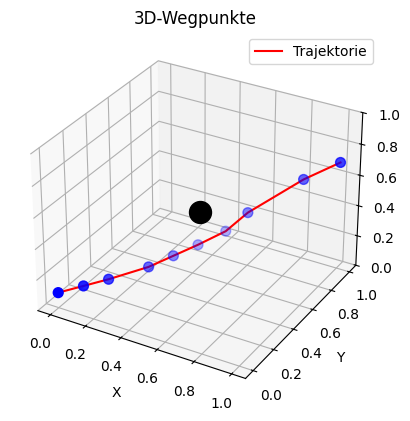

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
points= plan(2.0, "RRTStar", "PathLength", "None")

# Listen entpacken
xs, ys, zs = zip(*points)

# Plot vorbereiten
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Linie + Punkte
ax.plot(xs, ys, zs, color='red', label='Trajektorie')
ax.scatter(xs, ys, zs, color='blue', s=50)
ax.set_zlim(0, 1)
ax.scatter(0.5, 0.5, 0.5, color='black' , s =250)

# Achsenbeschriftung
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D-Wegpunkte")
ax.legend()
ax.grid(True)

plt.show()

In [38]:
import numpy as np

def load_waypoints():
    # Wegpunkte aus Datei laden
    waypoints = []
    with open("output.txt", "r") as f:
        for line in f:
            if line.strip():
                x, y, z = map(float, line.strip().split())
                waypoints.append(np.array([x, y, z]))
    return waypoints
    print(waypoints)
print(load_waypoints())

[array([0. , 0. , 0.1]), array([0.103115, 0.13281 , 0.132144]), array([0.206229, 0.265619, 0.164289]), array([0.305452, 0.389669, 0.199397]), array([0.404676, 0.513719, 0.234505]), array([0.539279, 0.666543, 0.294136]), array([0.653984, 0.750505, 0.391197]), array([0.768689, 0.834467, 0.488258]), array([0.872628, 0.91508 , 0.579931]), array([1. , 1. , 0.7])]


In [ ]:
visualisierung in isaac sim
action graphs
inverse kinematic 
forward kinematics
panda modell (roboter)

